#AI Knowledge Graph Builder for Enterprise Intelligence

#ISRO Mission Navigator

##Module 2: Entity & Relationship Extraction Engine

1.   Uses LLM-based NER (Named Entity Recognition)
2.   Intelligent Relation Extraction
1.   Creates structured triples (entity–relation–entity)



####STEP 1: SETUP GOOGLE COLAB ENVIRONMENT

In [ ]:
# Install Required Libraries
!pip install -U spacy
!pip install transformers==4.38.2 accelerate
!pip install neo4j
!pip install numpy==1.26.4


In [ ]:
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import spacy
from transformers import pipeline
from neo4j import GraphDatabase
print("spaCy version:", spacy.__version__)
print("Transformers pipeline available:", pipeline)
print("Neo4j driver imported:", GraphDatabase is not None)


spaCy version: 3.8.11
Transformers pipeline available: <function pipeline at 0x790347a809a0>
Neo4j driver imported: True


####STEP 2: LOAD PROCESSED DATA FROM MODULE-1

In [3]:
import pandas as pd
df = pd.read_csv("/content/07_standardized_data.csv")
df.head()


,satellite_name,launch_date,launch_vehicle,orbit,application,year,month,rocket_family,mission,orbit_cat,recent_launch
0,NISAR(NASA-ISRO),2025-07-30,GSLV-F16/NISAR Mission,SSO (Sun Synchronous Orbit),Earth Observation(Radar),2025,Jul,GSLV-F16/NISAR,NISAR,SSO,1
1,EOS-09,2025-05-18,PSLV-C61/EOS-09 Mission,SSO (Sun Synchronous Orbit),Earth Observation,2025,May,PSLV-C61/EOS-09,EOS-09,SSO,1
2,NVS-02(NavIC Series),2025-01-29,GSLV-F15/NVS-02 Mission,GTO (Geosynchronous Transfer Orbit),Navigation,2025,Jan,GSLV-F15/NVS-02,NVS-02,GTO,1
3,"SPADEX, POEM-4",2025-12-30,"PSLV-C60,SPADEX,POEM-4 Mission",LEO (Low Earth Orbit),In-Orbit Docking Experiment,2025,Dec,"PSLV-C60,SPADEX,POEM-4","PSLV-C60,SPADEX,POEM-4",LEO,1
4,Proba-3 (ESA),2024-12-05,PSLV-C59/Proba-3 Mission,HEO (High Elliptical Orbit),Formation Flying(Technology Demonstration),2024,Dec,PSLV-C59/Proba-3,Proba-3,HEO,1


####STEP 3: NAMED ENTITY RECOGNITION (NER)

CREATE TEXT COLUMN (VERY IMPORTANT)

In [11]:
# Check existing columns
print(df.columns)


Index(['satellite_name', 'launch_date', 'launch_vehicle', 'orbit',
       'application', 'year', 'month', 'rocket_family', 'mission', 'orbit_cat',
       'recent_launch', 'text'],
      dtype='object')


In [12]:
df['text'] = df.apply(
    lambda row: (
        f"The satellite {row['satellite_name']} was launched on {row['launch_date']} "
        f"using the {row['launch_vehicle']} launch vehicle. "
        f"It operates in {row['orbit']} orbit and is used for {row['application']} purposes."
    ),
    axis=1
)


In [13]:
df[['satellite_name', 'text']].head()


,satellite_name,text
0,NISAR(NASA-ISRO),The satellite NISAR(NASA-ISRO) was launched on...
1,EOS-09,The satellite EOS-09 was launched on 2025-05-1...
2,NVS-02(NavIC Series),The satellite NVS-02(NavIC Series) was launche...
3,"SPADEX, POEM-4","The satellite SPADEX, POEM-4 was launched on 2..."
4,Proba-3 (ESA),The satellite Proba-3 (ESA) was launched on 20...


3.1 spaCy NER

In [8]:
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

for i in range(3):
    print(spacy_ner(df['text'][i]))


[('NISAR(NASA-ISRO', 'ORG'), ('2025-07-30', 'DATE'), ('the GSLV-F16/NISAR Mission', 'ORG'), ('SSO', 'ORG'), ('Sun Synchronous Orbit', 'ORG'), ('Earth Observation(Radar', 'LOC')]
[('2025-05-18', 'DATE'), ('SSO', 'ORG'), ('Sun Synchronous Orbit', 'ORG'), ('Earth Observation', 'ORG')]
[('NVS-02(NavIC Series', 'EVENT'), ('2025-01-29', 'DATE'), ('GTO', 'LOC'), ('Navigation', 'ORG')]


3.2 Hugging Face NER (Transformer Model)

In [16]:
from transformers import pipeline

ner_pipeline = pipeline(
    task="token-classification",
    model="dbmdz/bert-large-cased-finetuned-conll03-english",
    aggregation_strategy="simple"
)


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TEST

In [17]:
results = ner_pipeline("Chandrayaan-3 was launched by LVM3 from Sriharikota in 2023.")
print(results)


[{'entity_group': 'MISC', 'score': 0.96319914, 'word': 'Chandrayaan - 3', 'start': 0, 'end': 13}, {'entity_group': 'ORG', 'score': 0.9579873, 'word': 'LVM3', 'start': 30, 'end': 34}, {'entity_group': 'LOC', 'score': 0.99097586, 'word': 'Sriharikota', 'start': 40, 'end': 51}]


####STEP 4: APPLY NER TO ENTIRE DATASET

In [18]:
all_entities = []

for idx, row in df.iterrows():
    text = row['text']
    ner_results = ner_pipeline(text)

    for ent in ner_results:
        all_entities.append({
            "row_id": idx,
            "entity": ent['word'],
            "type": ent['entity_group'],
            "confidence": ent['score']
        })

entities_df = pd.DataFrame(all_entities)
entities_df.head()


,row_id,entity,type,confidence
0,0,NISAR,ORG,0.957923
1,0,NASA,ORG,0.991431
2,0,ISRO,ORG,0.995856
3,0,G,MISC,0.669768
4,0,N,MISC,0.558087


In [20]:
entities_df

,row_id,entity,type,confidence
0,0,NISAR,ORG,0.957923
1,0,NASA,ORG,0.991431
2,0,ISRO,ORG,0.995856
3,0,G,MISC,0.669768
4,0,N,MISC,0.558087
...,...,...,...,...
1048,127,Low Earth Orbit,MISC,0.821880
1049,128,Aryabhata,MISC,0.943538
1050,128,C,MISC,0.770134
1051,128,1,MISC,0.397040


In [19]:
# Save the Entities:

entities_df.to_csv("ner_entities.csv", index=False)

####STEP 5: DEFINE RELATION EXTRACTION LOGIC

From your ISRO data:

Relationships we want:

| Relationship  | Meaning                    |
| ------------- | -------------------------- |
| launched_by   | Satellite → Launch Vehicle |
| orbit_type    | Satellite → Orbit          |
| used_for      | Satellite → Application    |
| launch_on     | Satellite → Launch Date    |
| rocket_family | Launch Vehicle → Family    |


####STEP 6: CREATE TRIPLES

In [21]:
triples = []
for i, row in df.iterrows():
    sat = row['satellite_name']
    triples.append((sat, "launched_by", row["launch_vehicle"]))
    triples.append((sat, "orbit_type", row["orbit"]))
    triples.append((sat, "used_for", row["application"]))
    triples.append((sat, "launch_on", row["launch_date"]))

    # optional: rocket family
    rv = row["launch_vehicle"]
    family = rv.split("-")[0] if "-" in rv else rv
    triples.append((rv, "rocket_family", family))

triples = list(set(triples))
triples[:10]


[('GSAT-15', 'used_for', 'Communication, Navigation'),
 ('GSLV-D5/GSAT-14', 'rocket_family', 'GSLV'),
 ('CMS-01', 'used_for', 'Communication'),
 ('CARTOSAT-2B', 'used_for', 'Earth Observation'),
 ('INSAT-3B', 'orbit_type', 'GSO (Geosynchronous Orbit)'),
 ('Rohini Satellite RS-D2', 'orbit_type', 'LEO (Low Earth Orbit)'),
 ('IRS-P2', 'used_for', 'Earth Observation'),
 ('INSAT-3E', 'used_for', 'Communication'),
 ('RISAT-1', 'launch_on', '2012-04-26'),
 ('GSAT-7', 'launched_by', 'Ariane-5 VA-215')]

####STEP 7: SAVE TRIPLES TO CSV + JSON

In [22]:
triples_df = pd.DataFrame(triples, columns=["Entity1","Relation","Entity2"])
triples_df.to_csv("triples.csv", index=False)
triples_df.to_json("triples.json", orient="records", indent=2)


####STEP 8: NEO4J GRAPH DATABASE SETUP
8.1 Install Neo4j

Follow one of these:

✅ Neo4j Desktop (Windows/Mac/Linux)
👉 https://neo4j.com/download/

OR

✅ Neo4j AuraDB Free (Cloud)
👉 https://neo4j.com/cloud/aura/

####STEP 9: CONNECT TO NEO4J FROM COLAB

In [23]:
uri = "neo4j+s://5be8df30.databases.neo4j.io"

In [24]:
from neo4j import GraphDatabase

uri = "neo4j+s://5be8df30.databases.neo4j.io"
user = "neo4j"
password = "jdrjnjNfgcFfBUY7PpsTE7YK92kLYXYlrCYZVOPcBiA"

driver = GraphDatabase.driver(uri, auth=(user, password))


####STEP 10: IMPORT TRIPLES INTO NEO4J

In [25]:
with driver.session() as session:
    for e1, rel, e2 in triples:
        session.run("""
        MERGE (a:Entity {name:$e1})
        MERGE (b:Entity {name:$e2})
        MERGE (a)-[r:REL {type:$rel}]->(b)
        """, e1=e1, e2=e2, rel=rel.upper())


MATCH (a)-[r]->(b)
RETURN a.name, type(r), b.name
LIMIT 25;


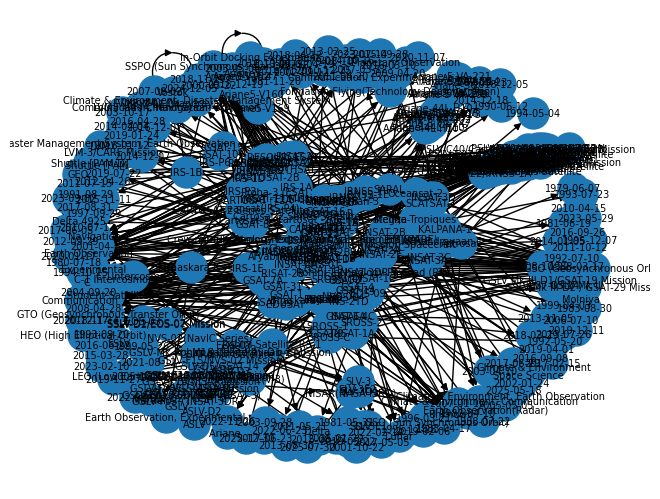

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(triples_df, "Entity1", "Entity2", create_using=nx.DiGraph())
nx.draw(G, with_labels=True, node_size=500, font_size=7)
plt.show()


#Visualizing ISRO Knowledge Graph

###OPTION 1: MIND MAP–STYLE GRAPH

In [29]:
#Install Required Lib
!pip install networkx matplotlib

In [30]:
# LOAD TRIPLES DATA
import pandas as pd

triples_df = pd.read_csv("/content/triples.csv")
triples_df.head()


,Entity1,Relation,Entity2
0,GSAT-15,used_for,"Communication, Navigation"
1,GSLV-D5/GSAT-14,rocket_family,GSLV
2,CMS-01,used_for,Communication
3,CARTOSAT-2B,used_for,Earth Observation
4,INSAT-3B,orbit_type,GSO (Geosynchronous Orbit)


In [31]:
#BUILD GRAPH STRUCTURE
import networkx as nx

G = nx.DiGraph()

for _, row in triples_df.iterrows():
    G.add_edge(row["Entity1"], row["Entity2"], label=row["Relation"])


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


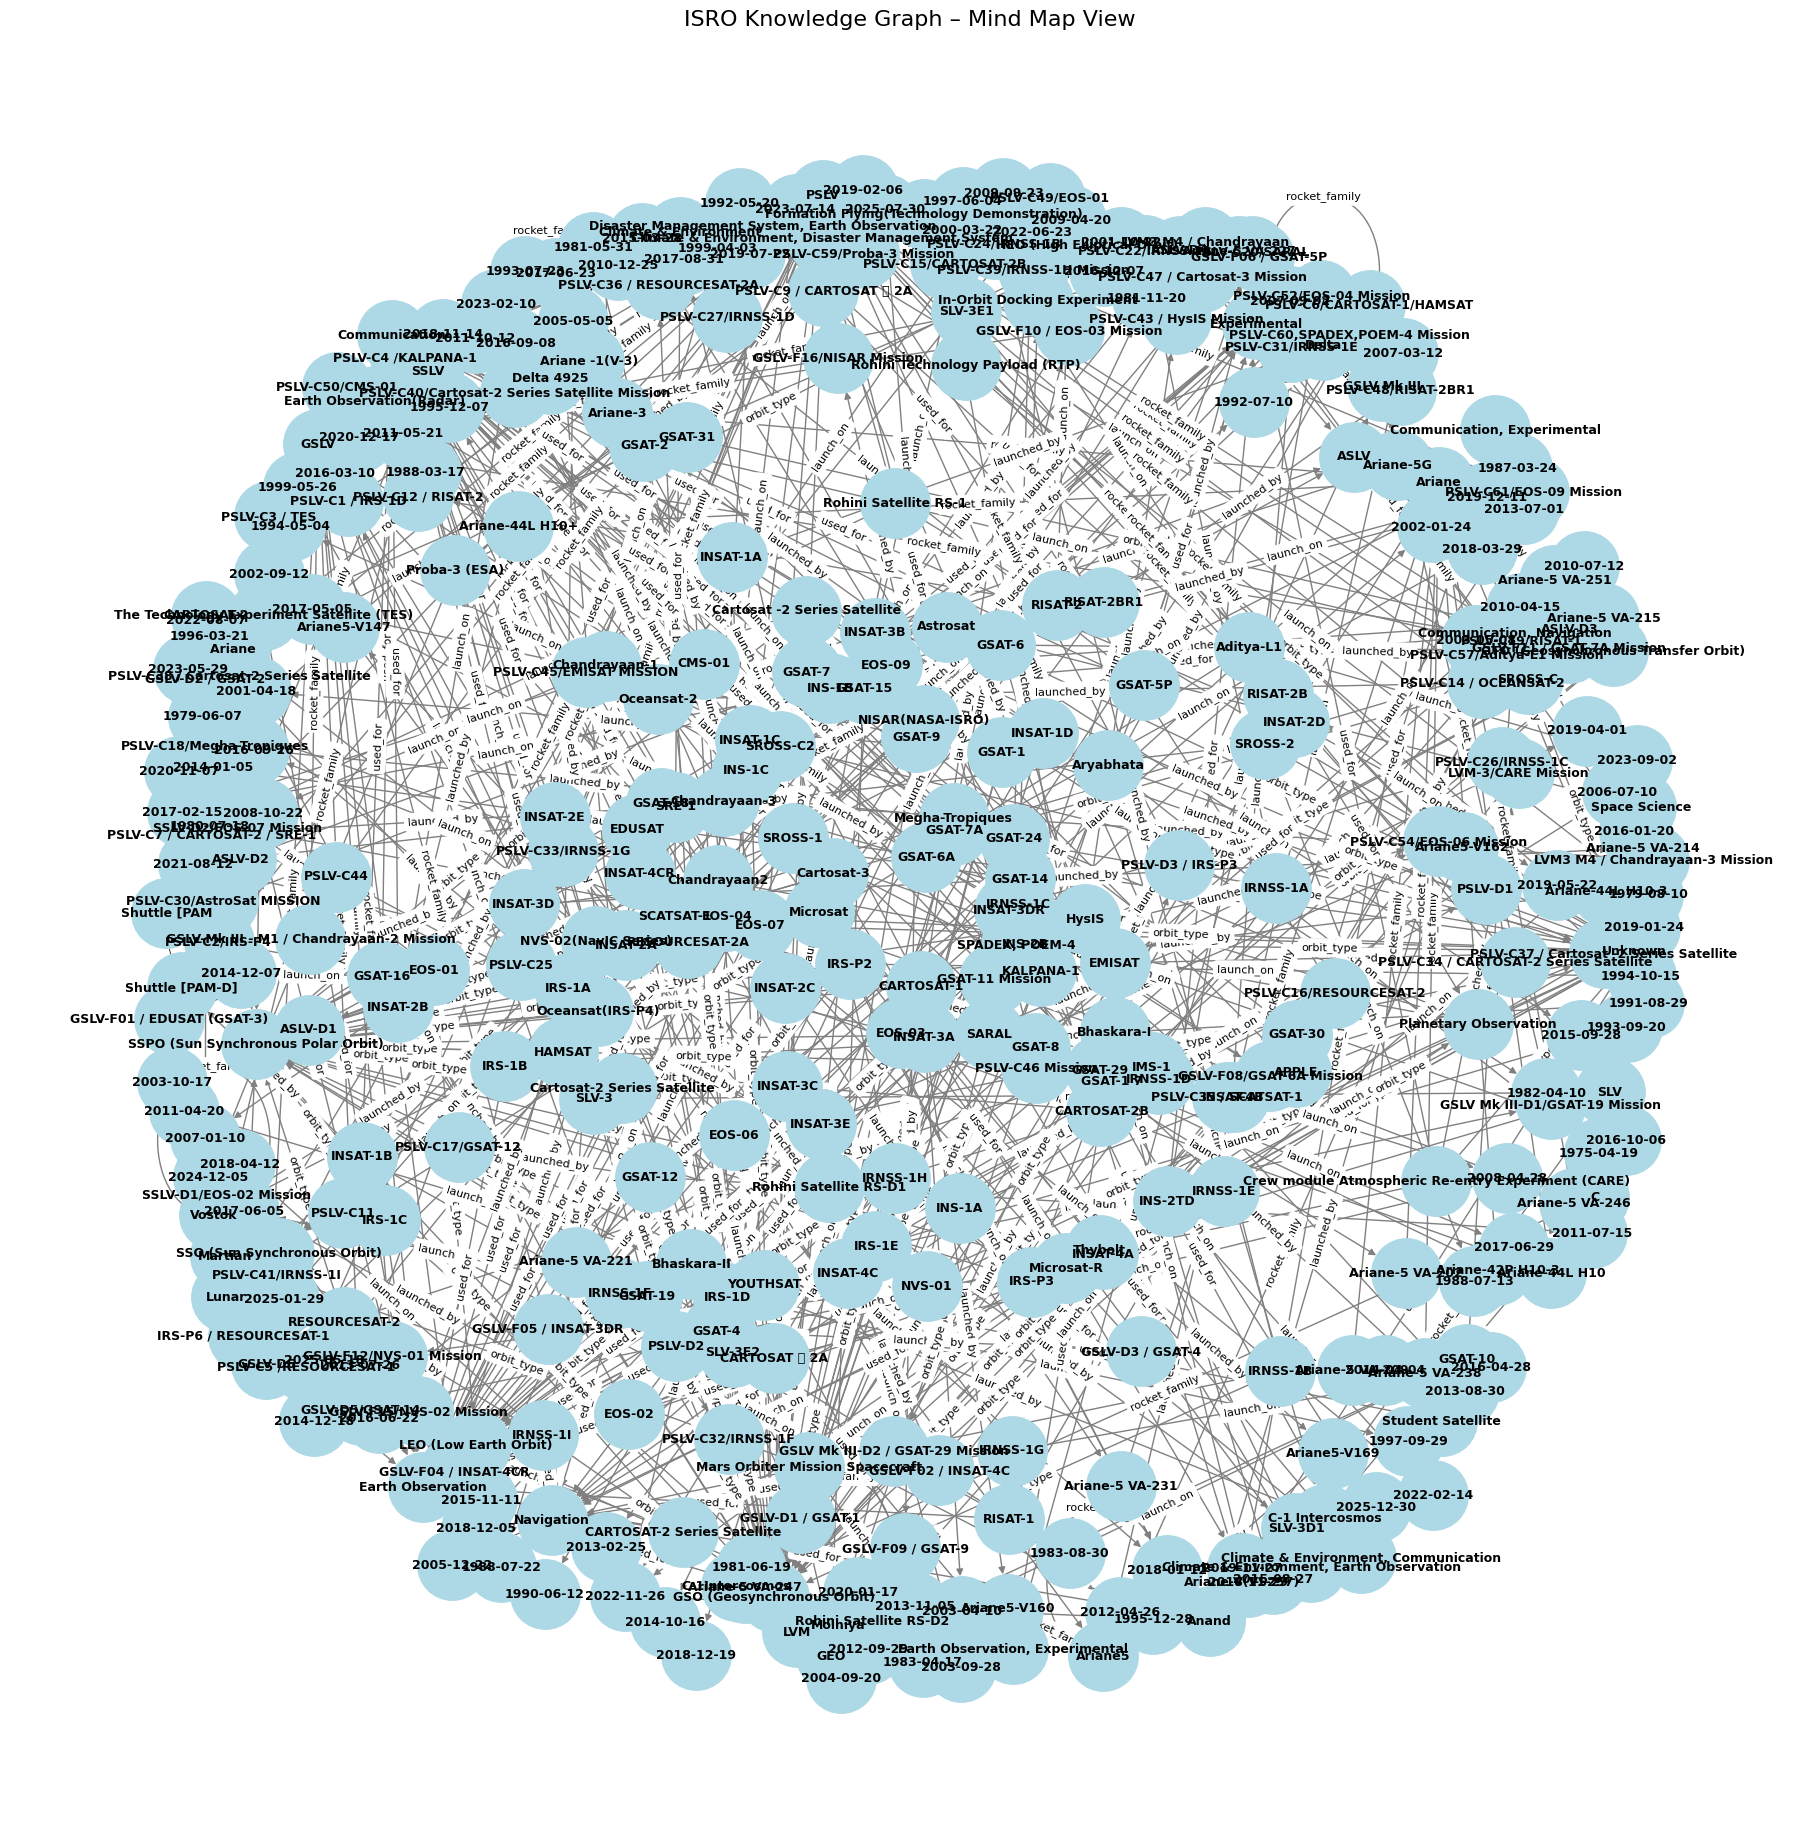

In [32]:
#CREATE MIND MAP LAYOUT (SPRING LAYOUT)
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
pos = nx.spring_layout(G, k=0.6, seed=42)

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2500,
    node_color="lightblue",
    font_size=9,
    font_weight="bold",
    edge_color="gray"
)

edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("ISRO Knowledge Graph – Mind Map View", fontsize=16)
plt.show()


###OPTION 2: INTERACTIVE GRAPH

In [33]:
#Install PYVIS
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.4 MB/s eta 0:00:00


In [37]:
#CREATE INTERACTIVE GRAPH
from pyvis.network import Network

net = Network(height="750px", width="100%", directed=True, notebook=True)

for _, row in triples_df.iterrows():
    net.add_node(row["Entity1"], label=row["Entity1"])
    net.add_node(row["Entity2"], label=row["Entity2"])
    net.add_edge(row["Entity1"], row["Entity2"], label=row["Relation"])


In [36]:
#DISPLAY IN COLAB
net.show("isro_knowledge_graph.html")


isro_knowledge_graph.html


###

In [38]:
from IPython.display import HTML
HTML("isro_knowledge_graph.html")


###OPTION 3: SATELLITE-CENTRIC MIND MAP

In [39]:
#FILTER FOR ONE SATELLITE
satellite_name = "Chandrayaan-3"

filtered = triples_df[
    (triples_df["Entity1"] == satellite_name) |
    (triples_df["Entity2"] == satellite_name)
]
filtered


,Entity1,Relation,Entity2
68,Chandrayaan-3,orbit_type,Lunar
326,Chandrayaan-3,launched_by,LVM3 M4 / Chandrayaan-3 Mission
461,Chandrayaan-3,used_for,Planetary Observation
475,Chandrayaan-3,launch_on,2023-07-14


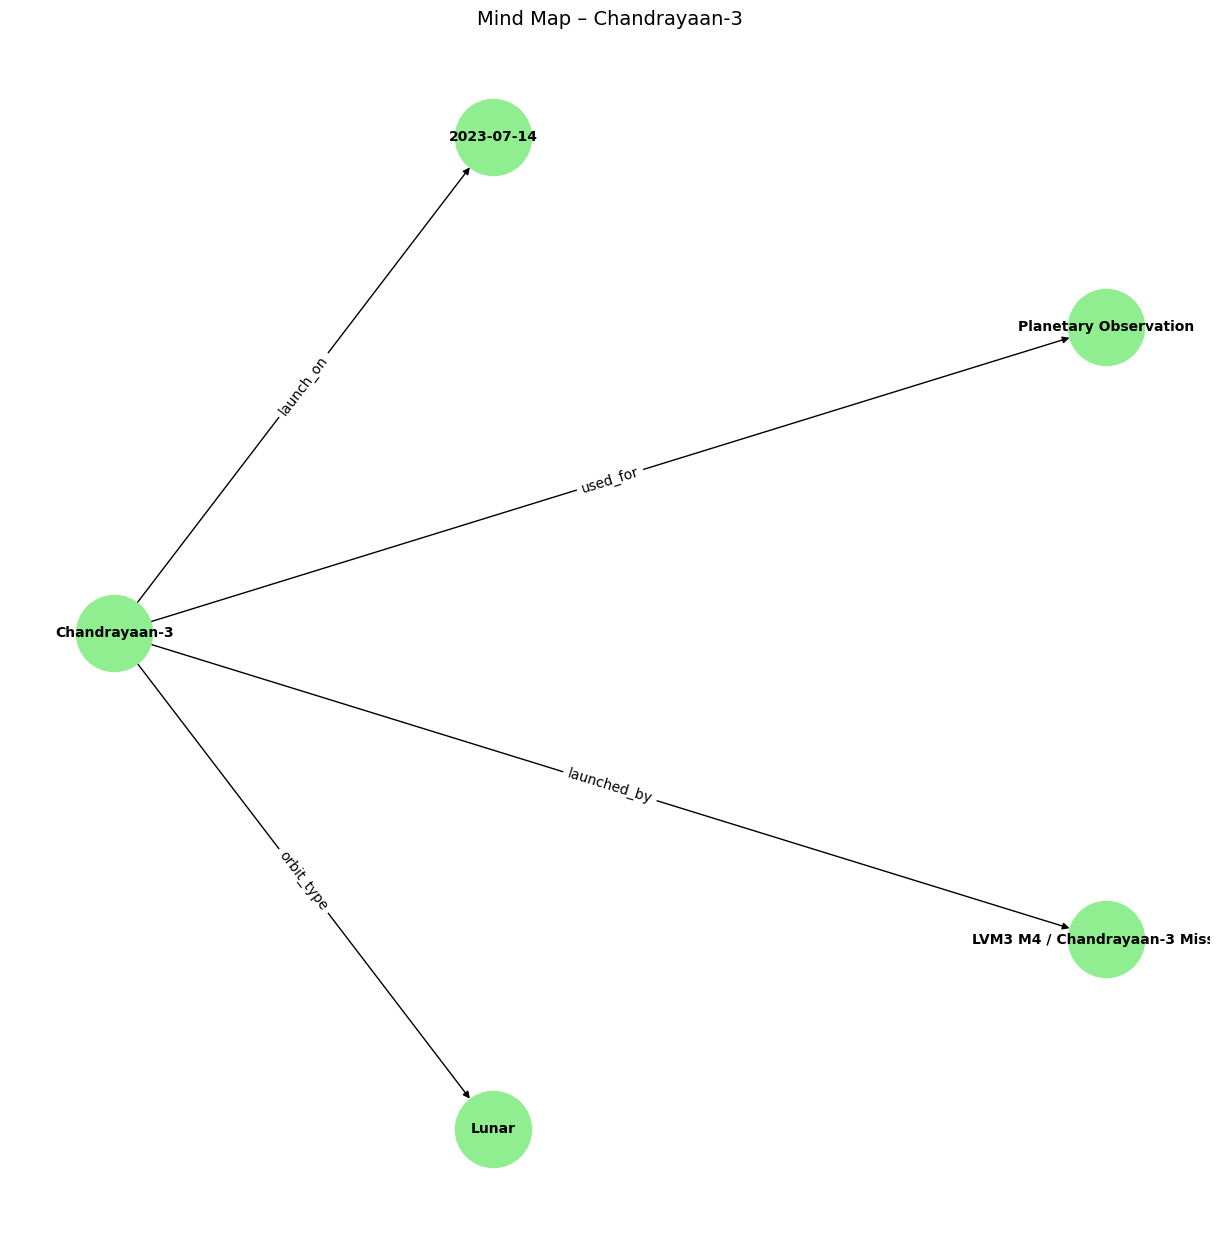

In [40]:
#DRAW CLEAN MIND MAP
G2 = nx.DiGraph()

for _, row in filtered.iterrows():
    G2.add_edge(row["Entity1"], row["Entity2"], label=row["Relation"])

plt.figure(figsize=(12, 12))
pos = nx.shell_layout(G2)

nx.draw(
    G2,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="lightgreen",
    font_size=10,
    font_weight="bold"
)

edge_labels = nx.get_edge_attributes(G2, "label")
nx.draw_networkx_edge_labels(G2, pos, edge_labels=edge_labels)

plt.title(f"Mind Map – {satellite_name}", fontsize=14)
plt.show()
